Lets first load few libraries. lphys is where we define our utility functions.

In [10]:
import lphys
import uproot
import matplotlib.pyplot as plt
import mplhep as hep
import numpy as np
import awkward as ak
from iminuit import cost, Minuit

We will load two files: one with data, the other with simulation. You can change the datafile to use the electrons dataset instead. You can also change the simulation for the Delphes simulation.

In [2]:
# input files
data_file = "singleMu2011_ntuple.root" # "singleEl2011_ntuple.root"
simu_file = "ppChargedCurrentFullsim_ntuple.root" # "delpheAnalysisW.root"

In [3]:
datafile = uproot.open(data_file)
simufile = uproot.open(simu_file)
datatree = datafile['LPHY2131analysis/WeakBosonsAnalysis']
simutree = simufile['LPHY2131analysis/WeakBosonsAnalysis']

Our work will be to select event of interest. We will achieve that by modifying the function below similarly to what we did for the Z boson.

This time, we will also define a _control region_, i.e. a complementary region similar to the signal region but where we hope to have only background.

In [4]:
# cuts
def signalSelection(events, branches=None):
    # first filter on the number of objects
    filter = (events.nMuons==1) & (events.nElectrons==0) & (events.nJets<10)
    selected = events[filter]
    # then apply a cut on the muon Pt
    filter = (selected.MuonsPt[:,0]>0)
    selected = selected[filter]
    # cut on the isolation
    filter = (selected.MuonIsolation[:,0]<0.5)
    selected = selected[filter]

    if branches:
        return selected[branches]
    else:
        return selected

def backgroundSelection(events, branches=None):
    # first filter on the number of objects
    filter = (events.nMuons==1) & (events.nElectrons==0) & (events.nJets<10)
    selected = events[filter]
    # then apply a cut on the muon Pt
    filter = (selected.MuonsPt[:,0]>0)
    selected = selected[filter]
    # cut on the isolation
    filter = (selected.MuonIsolation[:,0]>0.5)
    selected = selected[filter]
   
    if branches:
        return selected[branches]
    else:
        return selected

In [5]:
selected_data = lphys.analyzeTree(datatree,["transvMass"],selection=signalSelection)
selected_simu = lphys.analyzeTree(simutree,["transvMass"],selection=signalSelection)
control_data = lphys.analyzeTree(datatree,["transvMass"],selection=backgroundSelection)
control_simu = lphys.analyzeTree(simutree,["transvMass"],selection=backgroundSelection)

Lets define our binning first.

In [14]:
# This defines the binning for the fit and the display below.
xlim = (0,200)
nbins=50

# the unbinned data
data = ak.to_numpy(selected_data["transvMass"]).astype('double')

# the binned data
n, xe = np.histogram(data, bins=nbins, range=xlim) #n: bin content; xe: bin edges
cx = 0.5 * (xe[1:] + xe[:-1]) # bin centers
dx = np.diff(xe) # bin width

As a first check, we look at the transverse mass in the signal region. We compare the shape of signal and data distributions.
Here, the histograms are normalized to 1, so there is no information about the yield.

Do you see regions were background is apparently present in data, in addition to signal?

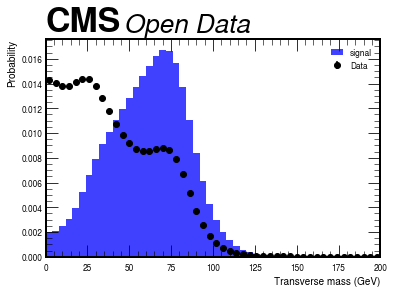

In [7]:
signal = lphys.sample(selected_simu["transvMass"],"signal","blue")
lphys.plot(selected_data["transvMass"], [signal], [], 
           xlim, 'Transverse mass (GeV)', 'Probability', 
           nbins, islog=False, color='g', density=True)

The equivalent distribution in the control region is presented below.
To check that there is no signal leaking in the control region, we also plot events from the signal sample that pass that selection.

Again, the distributions are normalized to unity, so you should only think in terms of shapes.

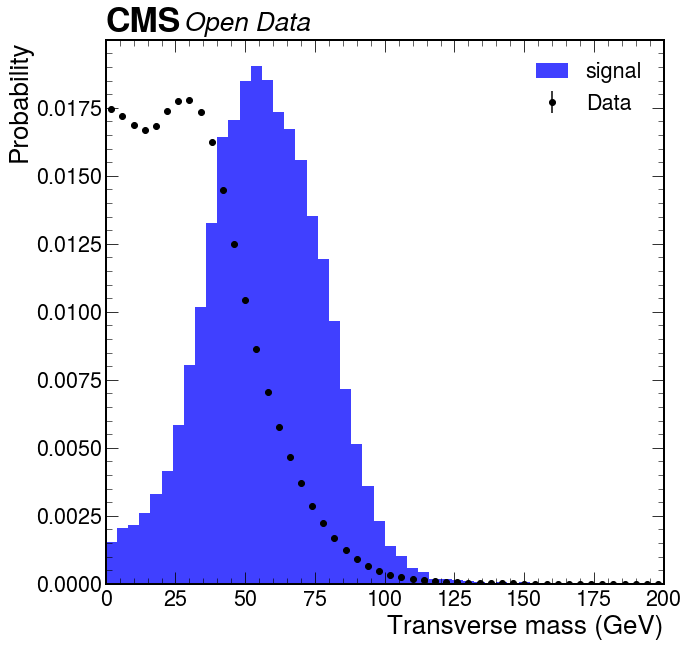

In [8]:
signal = lphys.sample(control_simu["transvMass"],"signal","blue")
lphys.plot(control_data["transvMass"], [signal], [], 
           xlim, 'Transverse mass (GeV)', 'Probability', 
           nbins, islog=False, color='g', density=True)

The next step is to make a fit.
- For the signal, we will build a pdf from the histogram of the MC simulation. 
- For the background, we will build a pdf from the histogram of the DATA in the control region. 

The total PDF is defined as the sum signal+background.

In [15]:
signal = lphys.sample(selected_simu["transvMass"],"signal MC","C0")
bkg    = lphys.sample(control_data["transvMass"],"background","C1")

s_histo,bin_edges = np.histogram(ak.to_numpy(signal.events), bins=nbins, range=xlim, density=False ) 
b_histo,bin_edges = np.histogram(ak.to_numpy(bkg.events),bins=nbins, range=xlim, density=False )

c = cost.Template(n, xe, (s_histo,b_histo), ("s","b"))

Before doing the fit, we initialize the PDF with initial parameters not far from what we need:

In [26]:
m = Minuit(c,1e7,5e7)
m.limits = (0, None)
m.interactive(lphys.Plotter(c, logscale=False, text = False, xlabel="Transverse Mass (GeV)", ylabel="Events"))

We then run the fit (Migrad) and compute better errors (Minos).

In [27]:
m.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 9.947e+04 (chi2/ndof = 2072.4)│              Nfcn = 104              │
│ EDM = 1.72e-09 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ s    │ 12.862e6  │  0.012e6  │            │            │    0    │         │       │
│ 1 │ b    │ 24.932e6  │  0.021e6  │            │            │    0    │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───┬─────────────────────┐
│   │         s         b │
├───┼─────────────────────┤
│ s │  1.49e+08 -1.39e+08 │
│ b │ -1.39e+08  4.31e+08 │
└───┴─────────────────────┘

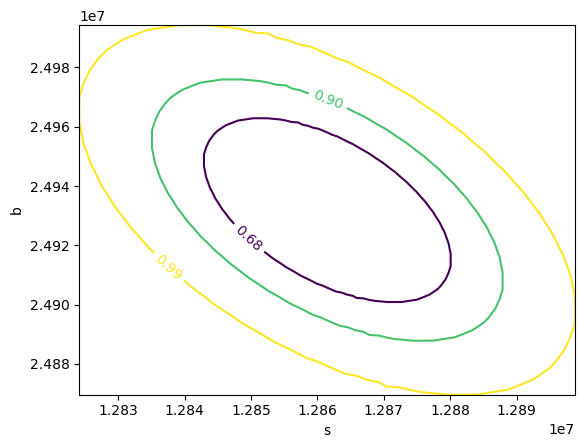

In [28]:
plt.style.use('default')
m.draw_mncontour("s", "b", cl=(0.68, 0.9, 0.99));

Let's do a nicer plot.
- For the signal, we use the signal simulation in the search region
- For the background, we use the data in the control region
- We then superimpose the data in the search region


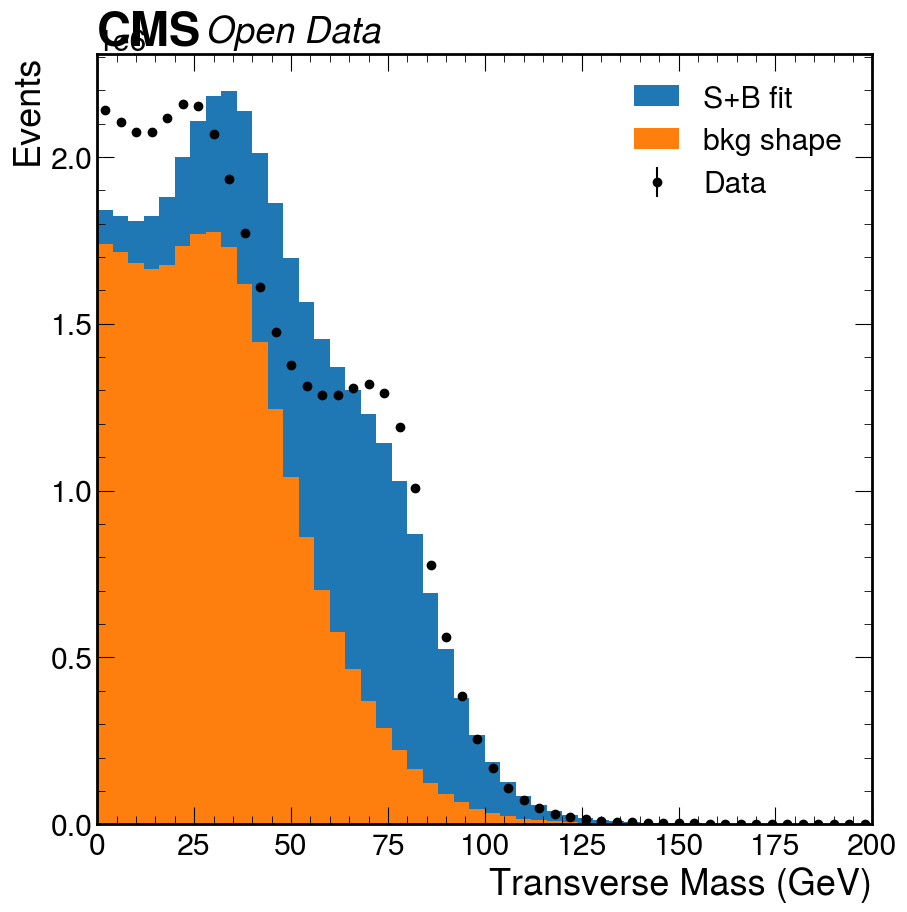

In [29]:
myplot = lphys.Plotter(c, logscale=False, legend=True, xlabel="Transverse Mass (GeV)", ylabel="Events", fill=True)
myplot(m.values)

Finally, we extract the fit parameters, uncertainties, and correlations.

Summary data:

Purity as s/N: 34.25 +/- 0.03 %
Purity as (N-b)/N: 33.62 +/- 0.06 %
Purity as s/s+b: 34.03 +/- 0.16 %
Selection efficiency: 38.59 %
N_Z = 12861501 +/- 12198
N_bkg = 24931814 +/- 20770
N_data = 37556927


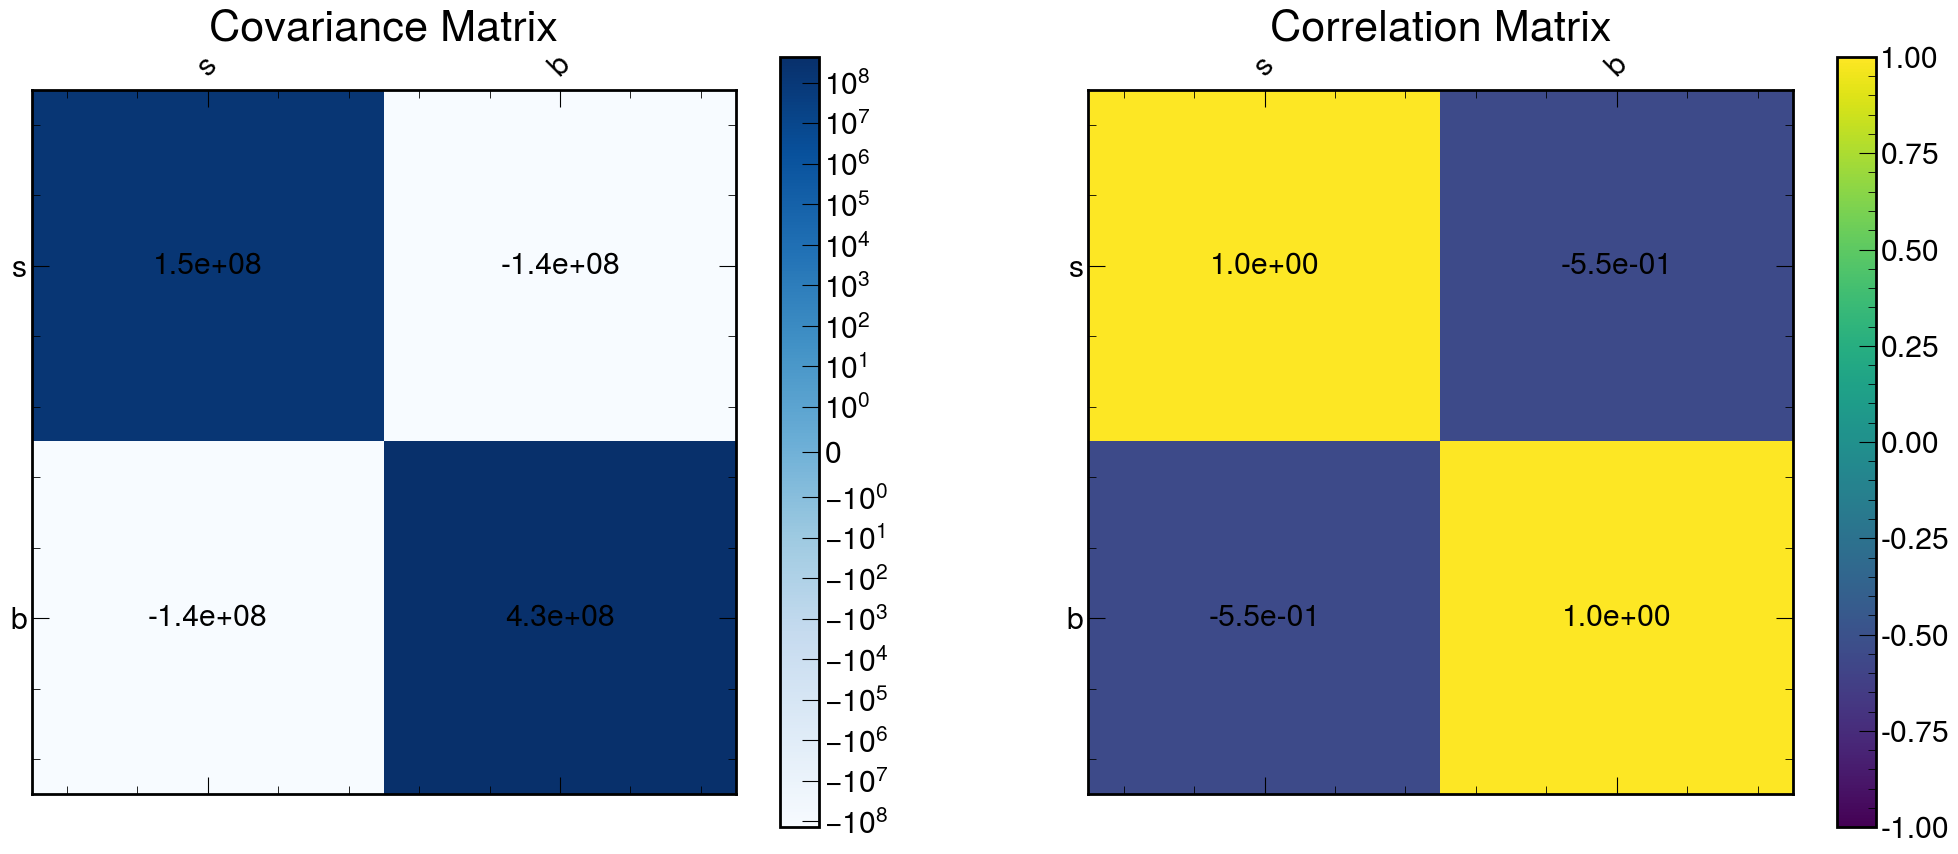

In [31]:
s = m.values['s']
b = m.values['b']
s_unc = m.errors['s']
b_unc = m.errors['b']
N = len(selected_data)
print("Summary data:\n")
print(f"Purity as s/N: { s/N*100:.2f} +/- {s_unc/N*100:.2f} %")
print(f"Purity as (N-b)/N: { (N-b)/N*100:.2f} +/- {b_unc/N*100:.2f} %")
print(f"Purity as s/s+b: {s/(s+b)*100:.2f} +/- {np.sqrt(2*(s_unc/s)**2+(b_unc/b)**2)*100:.2f} %")
print(f"Selection efficiency: {len(selected_simu)/simutree.num_entries*100:.2f} %")
print(f"N_Z = {s:.0f} +/- {s_unc:.0f}")
print(f"N_bkg = {b:.0f} +/- {b_unc:.0f}")
print(f"N_data = {N}")

cov = m.covariance
corr = lphys.correlation_from_covariance(cov)
fig, axs = plt.subplots(1, 2,figsize=(25, 10), sharey=False)
lphys.matrixPlot(fig,axs[1],corr,m.parameters,mrange=(-1,1))
lphys.matrixPlot(fig,axs[0],cov,m.parameters,"Blues",mrange="log")
axs[0].set_title('Covariance Matrix')
axs[1].set_title('Correlation Matrix')
plt.show()